In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from model import *
from feature_selection import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm  import LGBMRegressor
import xgboost as xgb
import xgbfir
from sklearn import linear_model
from itertools import combinations

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.max.columns', 500)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Feature

In [4]:
train_df = pd.read_csv('train_dataset/train_dataset.csv')
test_df = pd.read_csv('test_dataset/test_dataset.csv')
y_train = train_df['信用分']
x_train = train_df.drop('信用分', axis=1)
train_test = pd.concat((train_df.drop('信用分', axis=1), test_df))

# 剔除标准差太小的特征
std_df = pd.DataFrame(train_test.std(axis=0), columns=['std'])
print(std_df[std_df['std']<0.05])

# 特征：剔除二分类，且分布不一致的
def del_col(df, cols):
    for col in cols:
        if col in df.columns:
            df = df.drop(col, axis=1)
    return df
df_ncount = []
for col in train_test.columns:
    df_ncount.append([col, train_test[col].nunique(),
                      train_df[col].nunique(), test_df[col].nunique()])
df_ncount = pd.DataFrame(df_ncount, columns=['var', 'all', 'train', 'test'])
df_ncount_drop = df_ncount.loc[(df_ncount['train'] != df_ncount['test']) & (
    df_ncount['train'] <= 2)].iloc[:]
print('Drop dis', df_ncount_drop)

train_test = train_test.drop('用户编码', axis=1)
train_test.loc[train_test['用户话费敏感度'] == 0, '用户话费敏感度'] = 5
train_test.loc[train_test['用户年龄'] == 0, '用户年龄'] = np.nan
train_test['年龄是否缺失'] = train_test['用户年龄'].isnull()
train_test['是否黑名单客户'] = train_test['是否黑名单客户'].replace({0: 1, 1: 0})
train_test['缴费用户当前是否欠费缴费'] = train_test['缴费用户当前是否欠费缴费'].replace({0: 1, 1: 0})
train_test['当月是否去过高档商场消费'] = train_test['当月是否逛过福州仓山万达'] + \
    train_test['当月是否到过福州山姆会员店']
train_test.loc[train_test['当月是否去过高档商场消费'] >= 1, '当月是否去过高档商场消费'] = 1
train_test['用户欠费缴费或黑名单'] = (
    (train_test['是否黑名单客户'] + train_test['缴费用户当前是否欠费缴费']) >= 1).apply(int)

bi_combine_lst = ['是否经常逛商场的人', '当月是否看电影', '当月是否景点游览', '当月是否体育场馆消费']
combine_iter = combinations(range(4), 2)


def parse_bifeature(df, col1, col2):
    df[col1+'或'+col2] = ((df[col1] * df[col2]) >= 1).apply(int)
    return df


for idx1, idx2 in combine_iter:
    col1, col2 = bi_combine_lst[idx1], bi_combine_lst[idx2]
    train_test = parse_bifeature(train_test, col1, col2)

train_test['商场_电影_景点'] = train_test['是否经常逛商场的人'] + \
    train_test['当月是否看电影']+train_test['当月是否景点游览']

train_test['商场_电影_体育馆'] = train_test['是否经常逛商场的人'] + \
    train_test['当月是否看电影']+train_test['当月是否体育场馆消费']

train_test['商场_体育馆_景点'] = train_test['是否经常逛商场的人'] + \
    train_test['当月是否体育场馆消费']+train_test['当月是否景点游览']

train_test['体育馆_电影_景点'] = train_test['当月是否体育场馆消费'] + \
    train_test['当月是否看电影']+train_test['当月是否景点游览']

train_test['体育馆_电影_景点_商场'] = train_test['当月是否体育场馆消费'] + \
    train_test['当月是否看电影']+train_test['当月是否景点游览'] + train_test['是否经常逛商场的人']

train_test['缴费金额是否覆盖当月账单'] = train_test['缴费用户最近一次缴费金额（元）'] - \
    train_test['用户账单当月总费用（元）']
train_test['最近一次缴费是否超过平均消费额'] = train_test['缴费用户最近一次缴费金额（元）'] - \
    train_test['用户近6个月平均消费值（元）']
train_test['当月账单是否超过平均消费额'] = train_test['用户账单当月总费用（元）'] - \
    train_test['用户近6个月平均消费值（元）']
train_test['交通类APP使用次数'] = train_test['当月飞机类应用使用次数'] + \
    train_test['当月火车类应用使用次数']

# 离散化
lst = ['交通类APP使用次数', '当月物流快递类应用使用次数',
       '当月飞机类应用使用次数', '当月火车类应用使用次数', '当月旅游资讯类应用使用次数']


def discreteze(x):
    if x == 0:
        return 0
    elif x <= 5:
        return 1
    elif x <= 15:
        return 2
    elif x <= 50:
        return 3
    elif x <= 100:
        return 4
    else:
        return 5


for i in lst:
    train_test[i] = train_test[i].apply(discreteze)

# 针对长尾分布和异常值


def base_process(data):
    transform_value_feature = ['用户年龄', '用户网龄（月）', '当月通话交往圈人数',
                               '最近一次缴费是否超过平均消费额', '当月账单是否超过平均消费额',
                               '近三个月月均商场出现次数', '当月网购类应用使用次数',
                               '当月物流快递类应用使用次数', '当月金融理财类应用使用总次数',
                               '当月视频播放类应用使用次数', '当月飞机类应用使用次数',
                               '当月火车类应用使用次数', '当月旅游资讯类应用使用次数',
                               ]
    user_bill_fea = ['缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）',
                     '用户账单当月总费用（元）', '用户当月账户余额（元）',
                     ]
    log_features = ['当月网购类应用使用次数', '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数',
                    ]
    for col in transform_value_feature + log_features+user_bill_fea:
        ulimit = np.percentile(data[col][data[col].notnull()].values, 99.9)
        llimit = np.percentile(data[col][data[col].notnull()].values, 0.1)
        data.loc[(data[col] > ulimit) & (data[col].notnull()), col] = ulimit
        data.loc[(data[col] < llimit) & (data[col].notnull()), col] = llimit

    for col in user_bill_fea+log_features:
        data[col] = np.log1p(data[col])
    return data


train_test = base_process(train_test)

train_test['用户网龄（年）'] = train_test['用户网龄（月）']//12+1

agg_func = {
    '当月通话交往圈人数': ['mean'],
    '用户账单当月总费用（元）': ['mean'],
    #     '用户话费敏感度': ['mean'],
    #     '用户近6个月平均消费值（元）': ['mean'],
    #     '当月视频播放类应用使用次数': [ 'mean'],
    #     '当月金融理财类应用使用总次数': ['mean'],
}

agg_time_year = train_test.groupby('用户网龄（年）').agg(agg_func)

agg_time_year.columns = ['_'.join(col).strip()
                         for col in agg_time_year.columns.values]
agg_time_year.reset_index(inplace=True)

for col in agg_time_year.drop('用户网龄（年）', axis=1).columns:
    ulimit = np.percentile(agg_time_year[col].values, 99.9)
    llimit = np.percentile(agg_time_year[col].values, 0.1)
    agg_time_year.loc[agg_time_year[col] > ulimit, col] = ulimit
    agg_time_year.loc[agg_time_year[col] < llimit, col] = llimit

train_test = pd.merge(train_test, agg_time_year, on='用户网龄（年）', how='left')

# 账号余额 + 缴费费用
train_test['余额+缴费费用'] = train_test['缴费用户最近一次缴费金额（元）'] + \
    train_test['用户当月账户余额（元）']

Empty DataFrame
Columns: [std]
Index: []
Drop dis Empty DataFrame
Columns: [var, all, train, test]
Index: []


In [5]:
train_test.nunique()

用户实名制是否通过核实                 2
用户年龄                       71
是否大学生客户                     2
是否黑名单客户                     2
是否4G不健康客户                   2
用户网龄（月）                   268
用户最近一次缴费距今时长（月）             2
缴费用户最近一次缴费金额（元）           523
用户近6个月平均消费值（元）          22354
用户账单当月总费用（元）            16481
用户当月账户余额（元）               228
缴费用户当前是否欠费缴费                2
用户话费敏感度                     5
当月通话交往圈人数                 460
是否经常逛商场的人                   2
近三个月月均商场出现次数               93
当月是否逛过福州仓山万达                2
当月是否到过福州山姆会员店               2
当月是否看电影                     2
当月是否景点游览                    2
当月是否体育场馆消费                  2
当月网购类应用使用次数              8283
当月物流快递类应用使用次数               6
当月金融理财类应用使用总次数           7133
当月视频播放类应用使用次数           15968
当月飞机类应用使用次数                 6
当月火车类应用使用次数                 6
当月旅游资讯类应用使用次数               6
年龄是否缺失                      2
当月是否去过高档商场消费                2
用户欠费缴费或黑名单                  2
是否经常逛商场的人或当月是否看电影           2
是否经常逛商场的人或当月是否景点游览          2
是否经常逛商场的人或

In [6]:
# train_test['平均消费值_mean'] = train_test.groupby(['当月通话交往圈人数', '用户网龄（年）'])['用户近6个月平均消费值（元）'].transform(np.mean)

# train_test['当月通话交往圈人数_log'] = np.log1p(train_test['当月通话交往圈人数'])
# train_test.loc[train_test['当月通话交往圈人数_log']<2, '当月通话交往圈人数_log'] = 1
# bins = range(8)
# train_test['当月通话交往圈人数_log'] = pd.cut(
#     train_test['当月通话交往圈人数_log'], bins=bins, labels=[i for i in bins[:-1]]).astype('int')

# bins = range(8)
# train_test['用户近6个月平均消费值（元）_log'] = train_test['用户近6个月平均消费值（元）']

# train_test['用户近6个月平均消费值（元）_log'] = pd.cut(
#     train_test['用户近6个月平均消费值（元）_log'], bins=bins, labels=[i for i in bins[:-1]]).astype('int')

# # # 排名
# # def cat_rank(train_test, train_df, col):
# #     df_rank = train_df.groupby(col)['信用分'].mean().reset_index()
# #     df_rank[col + '_rank'] = df_rank['信用分'].rank()
# #     df_rank.drop('信用分', axis=1, inplace=True)
# #     train_test = pd.merge(train_test, df_rank, on=col, how='left')
# #     return train_test
# # train_test = cat_rank(train_test, pd.concat((train_test[:train_df.shape[0]], y_train), axis=1), '当月通话交往圈人数_log')

# train_test['交往圈人数+平均消费值log'] = train_test['用户近6个月平均消费值（元）_log'] + \
#     train_test['当月通话交往圈人数_log']
# train_test.drop(['用户近6个月平均消费值（元）_log', '当月通话交往圈人数_log'], axis=1, inplace=True)

# useless Feature
# 飞机和火车类应用至少使用一个
# 是否 ['缴费用户最近一次缴费金额（元）', '近三个月月均商场出现次数', '当月网购类应用使用次数', '当月金融理财类应用使用总次数',
#                 '当月视频播放类应用使用次数', '当月旅游资讯类应用使用次数']


# def parse_app(row, col1, col2):
#     if row[col1]==0 and row[col2]==0:
#         return 0
#     else:
#         return 1

# train_test['旅游资讯和视频播放类'] = train_test.apply(
#     lambda x: parse_app(x, '当月旅游资讯类应用使用次数', '当月视频播放类应用使用次数'), axis=1)
# train_test['旅游资讯和网购类应用'] = train_test.apply(
#     lambda x: parse_app(x, '当月旅游资讯类应用使用次数', '当月网购类应用使用次数'), axis=1)
# train_test['旅游资讯和金融理财类应用'] = train_test.apply(
#     lambda x: parse_app(x, '当月旅游资讯类应用使用次数', '当月金融理财类应用使用总次数'), axis=1)

# useless logY
# lgb_log_train, lgb_test = ModelRun(n_fold=10).run_oof(
#     lgbwrapper, x_train.values, y_train.values, x_test.values, logy=True)

# train_test['6个月占比总费用'] = train_test['用户近6个月平均消费值（元）'] / \
#     train_test['用户账单当月总费用（元）']+1
# # 不同充值路径
# train_test['不同充值途径'] = 0
# train_test.loc[(train_test['缴费用户最近一次缴费金额（元）'] %
#                       10 == 0) & train_test['缴费用户最近一次缴费金额（元）'] != 0, '不同充值途径'] = 1
# # 费用稳定性
# train_test['当前费用稳定性'] = train_test['用户账单当月总费用（元）'] / \
#     (train_test['用户近6个月平均消费值（元）']+1)
# # 当月话费/当月账户余额
# train_test['用户余额比例'] = train_test['用户账单当月总费用（元）']/(train_test['用户当月账户余额（元）']+1)
# 当月交往圈人数 * 用户网龄
# train_test['用户网龄交往圈人数'] = train_test['当月通话交往圈人数']*train_test['用户网龄（月）']
# 用户网龄 * 近 6 个月平均消费
# train_test['用户网龄近 6 个月平均消费'] = train_test['当月通话交往圈人数']*train_test['用户近6个月平均消费值（元）']

# 用户入网时间
# train_test['用户入网时间'] = train_test['用户年龄']- train_test['用户网龄（月）']/12
# train_test.loc[train_test['用户入网时间']<0, '用户入网时间'] = 0


# train_test['缴费+余额是否覆盖账单'] = train_test['用户当月账户余额（元）'] + \
#     train_test['缴费用户最近一次缴费金额（元）'] - train_test['用户账单当月总费用（元）']
# train_test['余额是否覆盖账单'] = train_test['用户当月账户余额（元）'] - train_test['用户账单当月总费用（元）']

# # 用户话费敏感度
# agg_func = {
#     '当月通话交往圈人数': ['mean', 'sum', 'std'],
#     '用户账单当月总费用（元）': ['mean', 'sum', 'std'],
#     '用户近6个月平均消费值（元）': ['mean', 'sum', 'std'],
#     '缴费金额是否覆盖当月账单': ['mean', 'sum', 'std'],
#     '当月账单是否超过平均消费额': ['mean', 'sum', 'std'],
#     '缴费用户最近一次缴费金额（元）': ['mean', 'sum', 'std'],
# }

# bill_sensitivity = train_test.groupby('用户话费敏感度').agg(agg_func)
# bill_sensitivity.columns = ['bill_sensitivity_'.join(col).strip()
#                          for col in bill_sensitivity.columns.values]
# bill_sensitivity.reset_index(inplace=True)

# for col in bill_sensitivity.drop('用户话费敏感度', axis=1).columns:
#     ulimit = np.percentile(bill_sensitivity[col].values, 99.9)
#     llimit = np.percentile(bill_sensitivity[col].values, 0.1)
#     bill_sensitivity.loc[bill_sensitivity[col] > ulimit, col] = ulimit
#     bill_sensitivity.loc[bill_sensitivity[col] < llimit, col] = llimit

# train_test = pd.merge(train_test, bill_sensitivity, on='用户话费敏感度', how='left')

In [7]:
# train_test['当月通话交往圈人数_log'] = np.log1p(train_test['当月通话交往圈人数'])
# train_test.loc[train_test['当月通话交往圈人数_log']<2, '当月通话交往圈人数_log'] = 1
# bins = range(8)
# train_test['当月通话交往圈人数_log'] = pd.cut(
#     train_test['当月通话交往圈人数_log'], bins=bins, labels=[i for i in bins[:-1]]).astype('int')

# bins = range(8)
# train_test['用户近6个月平均消费值（元）_log'] = train_test['用户近6个月平均消费值（元）']

# train_test['用户近6个月平均消费值（元）_log'] = pd.cut(
#     train_test['用户近6个月平均消费值（元）_log'], bins=bins, labels=[i for i in bins[:-1]]).astype('int')

# # # 排名
# # def cat_rank(train_test, train_df, col):
# #     df_rank = train_df.groupby(col)['信用分'].mean().reset_index()
# #     df_rank[col + '_rank'] = df_rank['信用分'].rank()
# #     df_rank.drop('信用分', axis=1, inplace=True)
# #     train_test = pd.merge(train_test, df_rank, on=col, how='left')
# #     return train_test
# # train_test = cat_rank(train_test, pd.concat((train_test[:train_df.shape[0]], y_train), axis=1), '当月通话交往圈人数_log')

# train_test['交往圈人数+平均消费值log'] = train_test['用户近6个月平均消费值（元）_log'] + \
#     train_test['当月通话交往圈人数_log']
# train_test.drop(['用户近6个月平均消费值（元）_log', '当月通话交往圈人数_log'], axis=1, inplace=True)

# useless Feature
# 飞机和火车类应用至少使用一个
# 是否 ['缴费用户最近一次缴费金额（元）', '近三个月月均商场出现次数', '当月网购类应用使用次数', '当月金融理财类应用使用总次数',
#                 '当月视频播放类应用使用次数', '当月旅游资讯类应用使用次数']


# def parse_app(row, col1, col2):
#     if row[col1]==0 and row[col2]==0:
#         return 0
#     else:
#         return 1

# train_test['旅游资讯和视频播放类'] = train_test.apply(
#     lambda x: parse_app(x, '当月旅游资讯类应用使用次数', '当月视频播放类应用使用次数'), axis=1)
# train_test['旅游资讯和网购类应用'] = train_test.apply(
#     lambda x: parse_app(x, '当月旅游资讯类应用使用次数', '当月网购类应用使用次数'), axis=1)
# train_test['旅游资讯和金融理财类应用'] = train_test.apply(
#     lambda x: parse_app(x, '当月旅游资讯类应用使用次数', '当月金融理财类应用使用总次数'), axis=1)

# useless logY
# lgb_log_train, lgb_test = ModelRun(n_fold=10).run_oof(
#     lgbwrapper, x_train.values, y_train.values, x_test.values, logy=True)

# train_test['6个月占比总费用'] = train_test['用户近6个月平均消费值（元）'] / \
#     train_test['用户账单当月总费用（元）']+1
# # 不同充值路径
# train_test['不同充值途径'] = 0
# train_test.loc[(train_test['缴费用户最近一次缴费金额（元）'] %
#                       10 == 0) & train_test['缴费用户最近一次缴费金额（元）'] != 0, '不同充值途径'] = 1
# # 费用稳定性
# train_test['当前费用稳定性'] = train_test['用户账单当月总费用（元）'] / \
#     (train_test['用户近6个月平均消费值（元）']+1)
# # 当月话费/当月账户余额
# train_test['用户余额比例'] = train_test['用户账单当月总费用（元）']/(train_test['用户当月账户余额（元）']+1)
# 当月交往圈人数 * 用户网龄
# train_test['用户网龄交往圈人数'] = train_test['当月通话交往圈人数']*train_test['用户网龄（月）']
# 用户网龄 * 近 6 个月平均消费
# train_test['用户网龄近 6 个月平均消费'] = train_test['当月通话交往圈人数']*train_test['用户近6个月平均消费值（元）']

# 用户入网时间
# train_test['用户入网时间'] = train_test['用户年龄']- train_test['用户网龄（月）']/12
# train_test.loc[train_test['用户入网时间']<0, '用户入网时间'] = 0


# train_test['缴费+余额是否覆盖账单'] = train_test['用户当月账户余额（元）'] + \
#     train_test['缴费用户最近一次缴费金额（元）'] - train_test['用户账单当月总费用（元）']
# train_test['余额是否覆盖账单'] = train_test['用户当月账户余额（元）'] - train_test['用户账单当月总费用（元）']

# # 用户话费敏感度
# agg_func = {
#     '当月通话交往圈人数': ['mean', 'sum', 'std'],
#     '用户账单当月总费用（元）': ['mean', 'sum', 'std'],
#     '用户近6个月平均消费值（元）': ['mean', 'sum', 'std'],
#     '缴费金额是否覆盖当月账单': ['mean', 'sum', 'std'],
#     '当月账单是否超过平均消费额': ['mean', 'sum', 'std'],
#     '缴费用户最近一次缴费金额（元）': ['mean', 'sum', 'std'],
# }

# bill_sensitivity = train_test.groupby('用户话费敏感度').agg(agg_func)
# bill_sensitivity.columns = ['bill_sensitivity_'.join(col).strip()
#                          for col in bill_sensitivity.columns.values]
# bill_sensitivity.reset_index(inplace=True)

# for col in bill_sensitivity.drop('用户话费敏感度', axis=1).columns:
#     ulimit = np.percentile(bill_sensitivity[col].values, 99.9)
#     llimit = np.percentile(bill_sensitivity[col].values, 0.1)
#     bill_sensitivity.loc[bill_sensitivity[col] > ulimit, col] = ulimit
#     bill_sensitivity.loc[bill_sensitivity[col] < llimit, col] = llimit

# train_test = pd.merge(train_test, bill_sensitivity, on='用户话费敏感度', how='left')

# 特征重要性

## xgbfir

In [8]:
x_train = train_test[:train_df.shape[0]]
xgb_cmodel = xgb.XGBRegressor().fit(x_train.astype('float'), y_train)
xgbfir.saveXgbFI(xgb_cmodel, feature_names=x_train.columns, OutputXlsxFile='特征重要性.xlsx')

feat_importance = pd.read_excel('特征重要性.xlsx')
feats_selected = feat_importance['Interaction']
train_test = train_test[feats_selected]

In [9]:
x_train, y_train, x_test = train_test[:train_df.shape[0]
                                      ], y_train, train_test[train_df.shape[0]:]

## Null importance

In [27]:
x_train = train_test[:train_df.shape[0]]
ni = Null_Importance(x_train, y_train)
actual_imp_df = ni.get_feature_importances()
null_imp_df = ni.build_null_distribution()
# feature = '用户网龄交往圈人数'
# ni.display_distributions(actual_imp_df, null_imp_df, feature)
ni.score(actual_imp_df, null_imp_df)
ni.check_importance_unrelated_feature(actual_imp_df, null_imp_df)

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [11]:
# feats = ['当月通话交往圈人数', '用户账单当月总费用（元）', '用户最近一次缴费距今时长（月）', '是否4G不健康客户', '余额+缴费费用',
#         '用户网龄（月）', '当月网购类应用使用次数', '最近一次缴费是否超过平均消费额', '用户账单当月总费用（元）_mean', '用户话费敏感度',
#         '缴费用户最近一次缴费金额（元）', '当月账单是否超过平均消费额', '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数', 
#         '用户年龄', '用户近6个月平均消费值（元）', '体育馆_电影_景点']
# train_test = train_test[feats]
# x_train, y_train, x_test = train_test[:train_df.shape[0]
#                                       ], y_train, train_test[train_df.shape[0]:]

# Raw 

## LGB

### mae

In [72]:
lgb_params = {
    'objective': 'regression_l1',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'reg_alpha': 2.2,
    'reg_lambda': 1.5,
    'max_depth': 8,
    'n_estimators': 2000,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'subsample_freq': 1,
    'learning_rate': 0.014,
    'random_state': 2019, 
    'n_jobs': 4
}

lgb = LGBMRegressor
lgbwrapper = GbmWrapper(lgb, params=lgb_params)

In [73]:
lgb_train, lgb_test = ModelRun(n_fold=10).run_oof(
    lgbwrapper, x_train.values, y_train.values, x_test.values)

lightGBM


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


1: Train 0.0719199 Val 0.0619443/0.0619443
--------------------------------------------------
2: Train 0.0717598 Val 0.0624619/0.0622031
--------------------------------------------------
3: Train 0.0712956 Val 0.0642252/0.0628771
--------------------------------------------------
4: Train 0.0718368 Val 0.0630484/0.0629199
--------------------------------------------------
5: Train 0.0705306 Val 0.0636247/0.0630609
--------------------------------------------------
6: Train 0.0713391 Val 0.0651213/0.0634043
--------------------------------------------------
7: Train 0.0715687 Val 0.0644912/0.0635596
--------------------------------------------------
8: Train 0.0709094 Val 0.0647408/0.0637072
--------------------------------------------------
9: Train 0.0716101 Val 0.0642735/0.0637701
--------------------------------------------------
10: Train 0.0712375 Val 0.0645746/0.0638506
--------------------------------------------------
Train:  [0.07191991714198265, 0.07175980904898252, 0.071295

### mse

MSE 对于两端极值的预测较为准确,而 MAE 则对于中间的预测更为准确,所以对函数预测的极值附近进行简单的加权修正

In [10]:
lgb_params2 = {
    'objective': 'regression_l2',
    'boosting_type':'gbdt', 
    'num_leaves': 31,
    'reg_alpha': 1.2,
    'reg_lambda': 1.8,
    'max_depth': 8,
    'n_estimators': 2000, 
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'subsample_freq': 1, 
    'learning_rate':0.024,
    'random_state': 2019,
    'n_jobs':-1
}

lgb2 = LGBMRegressor
lgbwrapper2 = GbmWrapper(lgb2, params=lgb_params2, eval_metric='rsme')
lgb_train, lgb_test = ModelRun(n_fold=10).run_oof(
    lgbwrapper, x_train.values, y_train.values, x_test.values, clf2=lgbwrapper2)

lightGBM


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


mae 预测 [668.67099596 637.66120226 644.76568407 651.66233356 611.86345531]
mse 预测 [668.49597265 636.11108648 647.71663402 648.55944509 610.21000549]
合并后的预测 [668.60098663 637.04115595 645.94606405 650.42117817 611.20207539]
y 实际值 [664 648 656 612 628]
1: Train 0.0721273 Val 0.0622355/0.0622355
--------------------------------------------------
mae 预测 [665.92364537 607.72620888 507.54329447 504.12280803 598.61584644]
mse 预测 [663.15569301 603.4084025  509.10199079 501.99420825 598.39838373]
合并后的预测 [664.81646443 605.99908633 508.166773   503.27136812 598.52886136]
y 实际值 [692 600 523 480 600]
2: Train 0.0721354 Val 0.0626879/0.0624617
--------------------------------------------------
mae 预测 [658.82592521 670.72709478 503.46725745 507.632146   558.39897656]
mse 预测 [659.0722146  672.70468093 495.40638346 509.28735511 559.08092962]
合并后的预测 [658.92444097 671.51812924 500.24290786 508.29422964 558.67175778]
y 实际值 [692 698 523 523 523]
3: Train 0.0702001 Val 0.0643745/0.0630993
-------------------

### 贝叶斯优化

#### MAE

In [11]:
lgb_adj_params = {
    'min_child_samples': (10, 30), 'min_split_gain': (0.001, 0.1), 'num_leaves': (24, 45),
    'feature_fraction': (0.1, 0.9), 'bagging_fraction': (0.8, 1), 'max_depth': (4, 8.99),
    'lambda_l1': (0, 5), 'lambda_l2': (0, 3), 'min_child_weight': (5, 50)
}

In [12]:
# lgbwrapper.optimize(x_train.values, y_train.values, param_grid=lgb_adj_params, eval_func='mae')

#### MSE

In [13]:
# lgbwrapper2.optimize(x_train.values, y_train.values, param_grid=adj_params, eval_func='rmse')

### 优化后的 LGB

#### bayes mae

In [74]:
## raw
lgb_params = {
    'objective': 'regression_l1',
    'boosting_type': 'gbdt',
    'num_leaves': 42,
    'reg_alpha': 3.403,
    'reg_lambda': 1.559,
    'max_depth': 6,
    'n_estimators': 2000,
    'subsample': 0.81,
    'colsample_bytree': 0.3,
    'subsample_freq': 1,
    'learning_rate': 0.014,
    'n_jobs': 4,
    'min_child_weight': 37.31,
    'min_child_samples': 14,
    'min_split_gain': 0.02059,
}
# lgb_params = {
#     'objective': 'regression_l1',
#     'boosting_type': 'gbdt',
#     'num_leaves': 34,
#     'reg_alpha': 1.9394,
#     'reg_lambda': 2.3,
#     'max_depth': 6,
#     'n_estimators': 2000,
#     'subsample': 0.85453,
#     'colsample_bytree': 0.7304,
#     'subsample_freq': 1,
#     'learning_rate': 0.014,
#     'n_jobs': 4,
#     'min_child_weight': 19.445,
#     'min_child_samples': 16,
#     'min_split_gain': 0.059,
# }
# lgb_params = {
#     'objective': 'regression_l1',
#     'boosting_type': 'gbdt',
#     'num_leaves': 26,
#     'reg_alpha': 1.992,
#     'reg_lambda': 2.288,
#     'max_depth': 7,
#     'n_estimators': 2000,
#     'subsample': 0.8368,
#     'colsample_bytree': 0.4129,
#     'subsample_freq': 1,
#     'learning_rate': 0.014,
#     'random_state': 2019, 
#     'min_child_weight': 18.53,
#     'min_child_samples': 17,
#     'min_split_gain': 0.06066,
#     'n_jobs': 4
# }
# lgb_params = {
#     'objective': 'regression_l1',
#     'boosting_type': 'gbdt',
#     'num_leaves': 42,
#     'reg_alpha': 2.0498,
#     'reg_lambda': 1.0645,
#     'max_depth': 7,
#     'n_estimators': 2000,
#     'subsample': 0.85982,
#     'colsample_bytree':0.442578,
#     'subsample_freq': 1,
#     'learning_rate': 0.014,
#     'random_state': 2019, 
#     'n_jobs': 4,
#     'min_child_weight': 28.8263,
#     'min_child_samples': 23,
#     'min_split_gain':0.046097,
# }
lgb = LGBMRegressor
lgbwrapper = GbmWrapper(lgb, params=lgb_params)
lgb_train, lgb_test = ModelRun(n_fold=10).run_oof(
    lgbwrapper, x_train.values, y_train.values, x_test.values)

lightGBM


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


1: Train 0.0715537 Val 0.0620311/0.0620311
--------------------------------------------------
2: Train 0.0713971 Val 0.0625846/0.0623079
--------------------------------------------------
3: Train 0.0706668 Val 0.0640942/0.0629033
--------------------------------------------------
4: Train 0.0711641 Val 0.0630153/0.0629313
--------------------------------------------------
5: Train 0.0702109 Val 0.0637589/0.0630968
--------------------------------------------------
6: Train 0.0710266 Val 0.0649855/0.0634116
--------------------------------------------------
7: Train 0.0711210 Val 0.0643748/0.0635492
--------------------------------------------------
8: Train 0.0709856 Val 0.0649001/0.0637181
--------------------------------------------------
9: Train 0.0712462 Val 0.0644851/0.0638033
--------------------------------------------------
10: Train 0.0702919 Val 0.0644030/0.0638633
--------------------------------------------------
Train:  [0.07155367653794524, 0.07139708607798202, 0.070666

#### bayes mse

In [9]:
# lgb_params2 = {
#     'objective': 'regression_l2',
#     'boosting_type':'gbdt', 
#     'num_leaves': 34,
#     'reg_alpha': 4.746,
#     'reg_lambda': 0.21,
#     'max_depth': 4,
#     'n_estimators': 2000, 
#     'subsample': 0.837,
#     'colsample_bytree': 0.5471,
#     'subsample_freq': 1, 
#     'learning_rate':0.024,
#     'random_state': 2019,
#     'n_jobs':-1,
#     'min_child_weight': 28.75,
#     'min_child_samples': 17,
#     'min_split_gain': 0.06959,
# }

# lgb_params2 = {
#     'objective': 'regression_l2',
#     'boosting_type':'gbdt', 
#     'num_leaves': 27,
#     'reg_alpha': 1.699,
#     'reg_lambda': 0.1323,
#     'max_depth': 4,
#     'n_estimators': 2000, 
#     'subsample': 0.8055,
#     'colsample_bytree': 0.5546,
#     'subsample_freq': 1, 
#     'learning_rate':0.024,
#     'random_state': 2019,
#     'n_jobs':-1,
#     'min_child_weight': 16.4,
#     'min_child_samples': 29,
#     'min_split_gain': 0.1,
# }
# lgb_params2 = {
#     'objective': 'regression_l2',
#     'boosting_type':'gbdt', 
#     'num_leaves': 31,
#     'reg_alpha': 1.2,
#     'reg_lambda': 1.8,
#     'max_depth': 8,
#     'n_estimators': 2000, 
#     'subsample': 0.8,
#     'colsample_bytree': 0.7,
#     'subsample_freq': 1, 
#     'learning_rate':0.024,
#     'random_state': 2019,
#     'n_jobs':-1,
#     'min_child_weight': 16.4,
#     'min_child_samples': 29,
#     'min_split_gain': 0.1,
# }
lgb_params2 = {
    'objective': 'regression_l2',
    'boosting_type':'gbdt', 
    'num_leaves': 31,
    'reg_alpha': 1.2,
    'reg_lambda': 1.8,
    'max_depth': 8,
    'n_estimators': 2000, 
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'subsample_freq': 1, 
    'learning_rate':0.024,
    'random_state': 2019,
    'n_jobs':-1,
    'min_child_weight': 16.4,
    'min_child_samples': 29,
    'min_split_gain': 0.1,
}
# lgb_params2 = {
#     'objective': 'regression_l2',
#     'boosting_type':'gbdt', 
#     'num_leaves': 31,
#     'reg_alpha': 2.49159,
#     'reg_lambda': 0.76465,
#     'max_depth': 6,
#     'n_estimators': 2000, 
#     'subsample': 0.93483,
#     'colsample_bytree': 0.38017,
#     'subsample_freq': 1, 
#     'learning_rate':0.024,
#     'random_state': 2019,
#     'n_jobs':-1,
#     'min_child_weight': 18.98874,
#     'min_child_samples': 25,
#     'min_split_gain': 0.03027,
# }
lgb2 = LGBMRegressor
lgbwrapper2 = GbmWrapper(lgb2, params=lgb_params2, eval_metric='rsme')
lgb_train, lgb_test = ModelRun(n_fold=10).run_oof(
    lgbwrapper, x_train.values, y_train.values, x_test.values, clf2=lgbwrapper2)

lightGBM


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


mae 预测 [549.96056025 651.03886364 655.93467949 637.04785359 643.41099003]
mse 预测 [541.03673755 652.32556515 654.93085818 636.16629409 647.27274425]
合并后的预测 [546.39103117 651.55354425 655.53315097 636.69522979 644.95569172]
y 实际值 [530 643 649 648 656]
1: Train 0.0715774 Val 0.0622645/0.0622645
--------------------------------------------------
mae 预测 [667.20525821 602.48038138 606.60437534 508.53255483 504.46216494]
mse 预测 [664.79311845 602.93143146 604.68950824 506.66959959 504.6244867 ]
合并后的预测 [666.24040231 602.66080141 605.8384285  507.78737273 504.52709365]
y 实际值 [692 600 600 523 480]
2: Train 0.0714341 Val 0.0627798/0.0625222
--------------------------------------------------
mae 预测 [504.00792367 671.44564781 503.94025564 507.81304142 557.48628242]
mse 预测 [501.29371674 672.9433853  496.45319309 510.3692712  559.76917015]
合并后的预测 [502.9222409  672.04474281 500.94543062 508.83553333 558.39943751]
y 实际值 [480 698 523 523 523]
3: Train 0.0708111 Val 0.0643829/0.0631424
-------------------

In [10]:
lgb_res = pd.DataFrame({'train_pred':lgb_train, 'test_pred':lgb_test})
lgb_res.to_csv('lgb_mse_res.csv', index=False)

### logY

#### mae

In [11]:
lgb = LGBMRegressor
lgbwrapper = GbmWrapper(lgb, params=lgb_params)
lgb_log_train, lgb_log_test = ModelRun(n_fold=10).run_oof(
    lgbwrapper, x_train.values, y_train.values, x_test.values, logy=True)

lightGBM


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


1: Train 0.0713253 Val 0.0621898/0.0621898
--------------------------------------------------
2: Train 0.0712977 Val 0.0626846/0.0624372
--------------------------------------------------
3: Train 0.0711436 Val 0.0642911/0.0630552
--------------------------------------------------
4: Train 0.0712755 Val 0.0630079/0.0630434
--------------------------------------------------
5: Train 0.0704604 Val 0.0637845/0.0631916
--------------------------------------------------
6: Train 0.0709589 Val 0.0651816/0.0635233
--------------------------------------------------
7: Train 0.0710406 Val 0.0645305/0.0636672
--------------------------------------------------
8: Train 0.0709891 Val 0.0649891/0.0638324
--------------------------------------------------
9: Train 0.0710757 Val 0.0645864/0.0639162
--------------------------------------------------
10: Train 0.0707403 Val 0.0645235/0.0639769
--------------------------------------------------
Train:  [0.07132527879359424, 0.07129770816625816, 0.071143

#### mse

In [12]:
lgb = LGBMRegressor
lgbwrapper2 = GbmWrapper(lgb, params=lgb_params2)
lgb_log_train, lgb_log_test = ModelRun(n_fold=10).run_oof(
    lgbwrapper, x_train.values, y_train.values, x_test.values, logy=True, clf2=lgbwrapper2)

lightGBM


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


mae 预测 [669.16719316 652.13197184 656.67423027 644.40310521 611.3060823 ]
mse 预测 [668.36590752 652.60579482 655.06814241 647.54254379 609.67881003]
合并后的预测 [668.84667891 652.32150103 656.03179513 645.65888064 610.65517339]
y 实际值 [664. 643. 649. 656. 628.]
1: Train 0.0711954 Val 0.0623050/0.0623050
--------------------------------------------------
mae 预测 [668.39640748 604.29741093 606.29894559 508.87185349 503.32013368]
mse 预测 [665.52715813 604.73225609 603.8433499  504.57592414 498.35392788]
合并后的预测 [667.24870774 604.47134899 605.31670731 507.15348175 501.33365136]
y 实际值 [692. 600. 600. 523. 480.]
2: Train 0.0713767 Val 0.0628803/0.0625926
--------------------------------------------------
mae 预测 [502.61132795 671.22680293 503.60803758 509.64307743 558.76460453]
mse 预测 [498.30256323 672.98024729 494.28904138 508.36319508 555.73112423]
合并后的预测 [500.88782206 671.92818067 499.8804391  509.13112449 557.55121241]
y 实际值 [480. 698. 523. 523. 523.]
3: Train 0.0706228 Val 0.0643645/0.0631833
----

#### 优化后的 mae 和 mse

##### mae

In [18]:
# lgb_params = {
#     'objective': 'regression_l1',
#     'boosting_type': 'gbdt',
#     'num_leaves': 44,
#     'reg_alpha': 0.33299,
#     'reg_lambda': 2.50384,
#     'max_depth': 9,
#     'n_estimators': 2000,
#     'subsample': 0.8481,
#     'colsample_bytree':0.51985,
#     'subsample_freq': 1,
#     'learning_rate': 0.014,
#     'random_state': 2019, 
#     'n_jobs': 4,
#     'min_child_weight': 49.9182,
#     'min_child_samples': 21,
#     'min_split_gain':0.029678,
# }
# lgb_params = {
#     'objective': 'regression_l1',
#     'boosting_type': 'gbdt',
#     'num_leaves': 44,
#     'reg_alpha': 0.33299,
#     'reg_lambda': 2.50384,
#     'max_depth': 9,
#     'n_estimators': 2000,
#     'subsample': 0.8481,
#     'colsample_bytree':0.51985,
#     'subsample_freq': 1,
#     'learning_rate': 0.014,
#     'random_state': 2019, 
#     'n_jobs': 4,
#     'min_child_weight': 49.9182,
#     'min_child_samples': 21,
#     'min_split_gain':0.029678,
# }
# lgb = LGBMRegressor
# lgbwrapper = GbmWrapper(lgb, params=lgb_params)
# lgb_train, lgb_test = ModelRun(n_fold=10).run_oof(
#     lgbwrapper, x_train.values, y_train.values, x_test.values)

##### mse

In [19]:
# lgb_params2 = {
#     'objective': 'regression_l2',
#     'boosting_type': 'gbdt',
#     'num_leaves': 26,
#     'reg_alpha': 1.92,
#     'reg_lambda': 1.2,
#     'max_depth': 8,
#     'n_estimators': 2000,
#     'subsample': 0.8819,
#     'colsample_bytree': 0.5818,
#     'subsample_freq': 1,
#     'learning_rate': 0.024,
#     'random_state': 2019,
#     'n_jobs': -1,
#     'min_child_weight': 20.058,
#     'min_child_samples': 15,
#     'min_split_gain': 0.03394,
# }
# lgb_params2 = {
#     'objective': 'regression_l2',
#     'boosting_type': 'gbdt',
#     'num_leaves': 39,
#     'reg_alpha': 3.87649,
#     'reg_lambda': 0.14744,
#     'max_depth': 4,
#     'n_estimators': 2000,
#     'subsample':0.91682,
#     'colsample_bytree':0.48433,
#     'subsample_freq': 1,
#     'learning_rate': 0.024,
#     'random_state': 2019,
#     'n_jobs': -1,
#     'min_child_weight': 28.5998,
#     'min_child_samples': 22,
#     'min_split_gain': 0.03166,
# }
# lgb = LGBMRegressor
# lgbwrapper2 = GbmWrapper(lgb, params=lgb_params2)
# lgb_log_train, lgb_log_test = ModelRun(n_fold=10).run_oof(
#     lgbwrapper, x_train.values, y_train.values, x_test.values, logy=True, clf2=lgbwrapper2)

In [13]:
lgb_logy_res = pd.DataFrame({'train_pred':lgb_log_train, 'test_pred':lgb_log_test})
lgb_logy_res.to_csv('lgb_mse_logy_res.csv', index=False)

## XGB

### MAE

In [19]:
xgb_params = {'eta': 0.03, 'max_depth': 8, 'subsample': 0.75, 'colsample_bytree': 0.75,
              'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 4,
              'lambda': 1.5, 'alpha': 2.2, 'min_child_weight': 12, 'max_delta_step': 2}

In [20]:
xgbwrapper1 = XgbWrapper(xgb_params)
# xgb_train, xgb_test = ModelRun(n_fold=10).run_oof(
#     xgbwrapper1, x_train.values, y_train.values, x_test.values)

### MSE

In [21]:
xgb_params2={'eta': 0.02, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4,
           'lambda':1.8, 'alpha':1.2, 'min_child_weight':12, 'max_delta_step':2, }

xgbwrapper2 = XgbWrapper(xgb_params2)
# xgb_train2, xgb_test2 = ModelRun(n_fold=10).run_oof(
#     xgbwrapper1, x_train.values, y_train.values, x_test.values, clf2=xgbwrapper2)

### 调整后的参数

#### mae

In [22]:
xgb_params_mae = {
    'eta': 0.09966, 'max_depth': 9, 'subsample': 0.8649, 'colsample_bytree': 0.2877, 'num_leaves': 43,
    'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 8, 'min_child_samples': 15,
    'lambda': 0.12355, 'alpha': 3.191, 'min_child_weight': 6.12, 'max_delta_step': 2, 'gamma': 2.72728,
}
# xgbwrapper_mae = XgbWrapper(xgb_params_mae)
# xgbwrapper_mae.optimize(x_train.values, y_train.values, param_grid=xgb_adj_params, eval_func='mae')

#### mse

In [23]:
xgb_params_mse = {
    'eta': 0.28716, 'max_depth': 8, 'subsample': 0.51, 'colsample_bytree': 0.54773, 'num_leaves':41,
    'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 8, 'min_child_samples': 17,
    'lambda': 1.5069, 'alpha': 3.45311, 'min_child_weight': 36.447, 'max_delta_step': 2, 'gamma': 5.96818,
}
# xgbwrapper_mse = XgbWrapper(xgb_params_mse)
# xgbwrapper_mse.optimize(x_train.values, y_train.values, param_grid=xgb_adj_params, eval_func='rmse')

In [24]:
### XGBoost Train0.07971_Test0.06323

# Stacking

In [45]:
lgb_res = pd.read_csv('lgb_mse_res.csv')
lgb_logy_res = pd.read_csv('lgb_mse_logy_res.csv')
xgb_res = pd.read_csv('xgb_mse.res.csv')

In [46]:
train_stack = np.vstack(
    (lgb_res['train_pred'].values, lgb_logy_res['train_pred'].values, xgb_res['train_pred'].values)).transpose()
test_stack = np.vstack(
    (lgb_res['test_pred'].values, lgb_logy_res['test_pred'].values, xgb_res['test_pred'].values)).transpose()

In [47]:
bayesridgle_wrapper = SklearnWrapper(linear_model.BayesianRidge())
train_stack_pred, test_stack_pred = ModelRun(n_fold=10).run_oof(
    bayesridgle_wrapper, train_stack, y_train.values, test_stack)

BayesianRidge


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


1: Train 0.0640946 Val 0.0621014/0.0621014
--------------------------------------------------
2: Train 0.0640343 Val 0.0625958/0.0623486
--------------------------------------------------
3: Train 0.0638421 Val 0.0642601/0.0629858
--------------------------------------------------
4: Train 0.0639824 Val 0.0630619/0.0630048
--------------------------------------------------
5: Train 0.0638901 Val 0.0637844/0.0631607
--------------------------------------------------
6: Train 0.0637416 Val 0.0652853/0.0635148
--------------------------------------------------
7: Train 0.0638371 Val 0.0642184/0.0636154
--------------------------------------------------
8: Train 0.0637646 Val 0.0649717/0.0637849
--------------------------------------------------
9: Train 0.0638290 Val 0.0643651/0.0638494
--------------------------------------------------
10: Train 0.0638224 Val 0.0643652/0.0639009
--------------------------------------------------
Train:  [0.06409457543696803, 0.0640343483822475, 0.0638421

stacking 的结果不是很理想

# 最终结果

In [48]:
train_preds = pd.DataFrame(np.column_stack((train_stack, y_train.values.reshape(-1, 1))), columns=['lgb', 'lgb_logy', 'xgb', 'y'])
test_preds = pd.DataFrame(np.column_stack(test_stack), columns=['lgb', 'lgb_logy', 'xgb', 'y'])

## 针对 lgb，lgb_logy, 和 xgb 预测结果的差值做特征

In [14]:
!mkdir submission

子目录或文件 submission 已经存在。


In [53]:
train_preds['lgblogy_diff'] = abs(train_preds['lgb_logy'] - train_preds['y'])
train_preds['xgbdiff'] = abs(train_preds['xgb'] - train_preds['y'])
train_preds['mindiff'] = abs(train_preds[['lgb', 'lgb_logy', 'xgb']].min(1)-train_preds['y'])
train_preds['lgbdiff'] = abs(train_preds['lgb']-train_preds['y'])

lgb 	 0.06391919234529914
lgb_logy 	 0.06394950437161123
xgb 	 0.06327199651826901
rank 5000
94697.58368925682 95095.03073120117 94713.43906695438
43710.580993652344
41725.699895428


C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

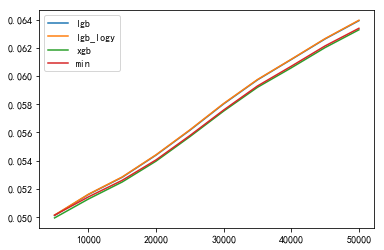

In [54]:
for i in ['lgb', 'lgb_logy', 'xgb']:
    print(i, '\t', 1/(1+mean_absolute_error(train_preds[i], train_preds['y'])))

low_bins = np.arange(0, 51000, 5000)[1:]

low_res = np.zeros((4, len(low_bins)))


def eval_function(array1, y):
    return 1/(1+mean_absolute_error(array1, y))


train_preds['min'] = train_preds[['lgb', 'lgb_logy', 'xgb']].min(1)
train_preds['rank'] = train_preds['lgb_logy'].rank()

for i, r in enumerate(low_bins):
    low = train_preds.loc[train_preds['rank'] < r, :]
    le = [eval_function(low[j], low['y'])
          for j in ['lgb', 'lgb_logy', 'xgb', 'min']]
    if i == 0:
        print('rank', r)
        low['logdiff'] = abs(low['lgb_logy'] - low['y'])
        low['xgbdiff'] = abs(low['xgb'] - low['y'])
        low['mindiff'] = abs(low['min']-low['y'])
        print(low['logdiff'].sum(),
              low['xgbdiff'].sum(), low['mindiff'].sum())
        # logdiff 与 xgb 差异较小的和
        print(abs(low[low['logdiff'] > low['xgbdiff']]['xgb'] -
                  low[low['logdiff'] > low['xgbdiff']]['y']).sum())
        print(abs(low[low['logdiff'] < low['xgbdiff']]['lgb_logy'] -
                  low[low['logdiff'] < low['xgbdiff']]['y']).sum())
    low_res[:, i] = le

low_res_df = pd.DataFrame(low_res, columns=low_bins, index=[
                          'lgb', 'lgb_logy', 'xgb', 'min']).T
# 横坐标代表阈值，纵坐标代表小于这个阈值的预测值的损失
low_res_df.plot()

不同阈值下，还是 lgb_logy 的表现最好。低阈值时，xgb 和 min 的损失与 lgb_logy 的差距不是很明显。

以与 label 差距最小的取值对 min，lgb, lgblogy, xgb 结果重新做一次分类

In [77]:
m = np.array(['lgb_logy', 'xgb', 'lgb'])
min_models = m[train_preds[['lgblogy_diff', 'xgbdiff', 'lgbdiff']].values.argmin(1)]
train_preds['target'] = min_models

In [78]:
train_preds.head()

,lgb,lgb_logy,xgb,y,lgblogy_diff,xgbdiff,mindiff,lgbdiff,min,rank,target
0,668.857645,669.167193,670.995361,664.0,5.167193,6.995361,4.857645,4.857645,668.857645,48130.0,lgb
1,549.960560,547.483326,538.716553,530.0,17.483326,8.716553,8.716553,19.960560,538.716553,2858.0,xgb
2,651.038864,652.131972,654.624084,643.0,9.131972,11.624084,8.038864,8.038864,651.038864,41013.0,lgb
3,655.934679,656.674230,659.238159,649.0,7.674230,10.238159,6.934679,6.934679,655.934679,43477.0,lgb
4,637.047854,637.231204,638.749695,648.0,10.768796,9.250305,10.952146,10.952146,637.047854,30880.0,xgb


In [79]:
train_preds[['lgblogy_diff', 'xgbdiff', 'lgbdiff', 'target']].head(10)

,lgblogy_diff,xgbdiff,lgbdiff,target
0,5.167193,6.995361,4.857645,lgb
1,17.483326,8.716553,19.960560,xgb
2,9.131972,11.624084,8.038864,lgb
3,7.674230,10.238159,6.934679,lgb
4,10.768796,9.250305,10.952146,xgb
5,11.596895,11.029785,12.589010,xgb
6,40.562197,39.927368,40.073386,xgb
7,16.693918,15.962769,16.698736,xgb
8,41.935709,41.164001,40.500871,lgb
9,29.845979,30.357483,29.903450,lgb_logy


In [80]:
pd.Series(min_models).value_counts()

xgb         21843
lgb_logy    14138
lgb         14019
dtype: int64

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


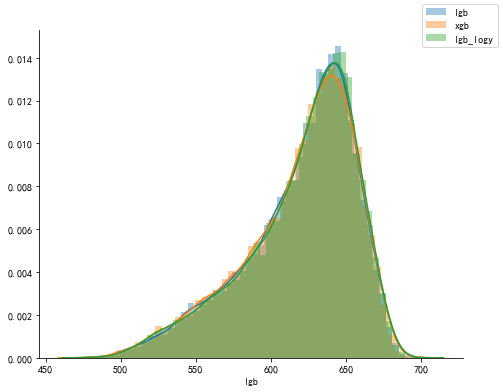

In [81]:
g = sns.FacetGrid(train_preds, hue='target')
g.map(sns.distplot, 'lgb')
g.fig.set_size_inches(8, 6)
g.fig.legend()

In [82]:
probs = train_preds['target'].value_counts()/50000

In [83]:
probs

xgb         0.43686
lgb_logy    0.28276
lgb         0.28038
Name: target, dtype: float64

In [84]:
test_stack = pd.DataFrame(test_stack, columns=['lgb', 'lgb_logy', 'xgb'])

In [23]:
res = np.zeros((50000, 1))
random_state = [1, 2019, 322]

In [97]:
# 分别用随机采样和比例的方式进行处理
test_preds['y_test_pred'] = 0.43686*test_preds['xgb'] + \
    0.28276*test_preds['lgb_logy']+0.28038*test_preds['lgb']
train_preds['y_test_pred'] = 0.43686*train_preds['xgb'] + \
    0.28276*train_preds['lgb_logy']+0.28038*train_preds['lgb']

In [89]:
def parse_prob(row, state):
    return row.sample(n=1, weights=probs, random_state=state).values[0]

In [ ]:
test_preds['y_test_pred_sample'] = test_preds[[
    'xgb', 'lgb_logy', 'lgb']].apply(lambda x: parse_prob(x, 0), axis=1)

In [95]:
train_preds['y_test_pred_sample'] = train_preds[[
    'xgb', 'lgb_logy', 'lgb']].apply(lambda x: parse_prob(x, 1), axis=1)

In [98]:
print(1/(1+mean_absolute_error(train_preds['y_test_pred'], train_preds['y'])))
print(1/(1+mean_absolute_error(train_preds['y_test_pred_sample'], train_preds['y'])))

0.06394109799297992
0.06394950437161123


In [102]:
res = pd.DataFrame(np.column_stack((test_df['用户编码'].values, np.round(test_preds['y_test_pred'], 0))), columns=['id', 'score'])
res['score'] = res['score'].astype('int')
res.to_csv('submission/submission_y_test_prop.csv',  index=False, encoding='utf-8')

In [103]:
res = pd.DataFrame(np.column_stack((test_df['用户编码'].values, np.round(test_preds['y_test_pred_sample'], 0))), columns=['id', 'score'])
res['score'] = res['score'].astype('int')
res.to_csv('submission/submission_y_test_sample.csv',  index=False, encoding='utf-8')

In [112]:
# 利用与 label 差异最小的一列和原始数据做训练，变成一个分类任务，应用在测试集上，但效果不理想。
# from sklearn.metrics import log_loss
# import xgboost as xgb

# xgb_params = {'eta': 0.03, 'max_depth': 8, 'subsample': 0.75, 'colsample_bytree': 0.75, 'num_class':4,
#               'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'silent': True, 'nthread': 4,
#               'lambda': 1.5, 'alpha': 2.2, 'min_child_weight': 12, 'max_delta_step': 2}
# dtrain = xgb.DMatrix(x_train.values, label=y_train)
# watchlist = [(dtrain, 'train')]
# xgbclf = xgb.train(xgb_params, dtrain, 5000, evals=watchlist, verbose_eval=200,
#                                  early_stopping_rounds=100)
# xgb_test_pred = xgbclf.predict(xgb.DMatrix(x_test.values))

# pd.DataFrame(xgb_test_pred, columns=['lgb_logy', 'xgb', 'min', 'lgb']).to_csv(
#     'xgb_test_pred.csv', index=False)

# xgb_test_pred = pd.Series(le.inverse_transform(xgb_test_pred.argmax(1)))
# xgb_test_pred.value_counts()

# params = {
#     'objective': 'multiclass',
#     'boosting_type': 'gbdt',
#     'num_leaves': 31,
#     'num_class': 4,
#     'reg_alpha': 1.2,
#     'reg_lambda': 1.8,
#     'max_depth': 8,
#     'n_estimators': 2000,
#     'subsample': 0.8,
#     'colsample_bytree': 0.7,
#     'subsample_freq': 1,
#     'learning_rate': 0.024,
#     'random_state': 2019,
#     'n_jobs': -1,
#     'min_child_weight': 16.4,
#     'min_child_samples': 29,
#     'min_split_gain': 0.1,
# }
# lgtrain = lgb.Dataset(x_train.values, y_train)
# lgbmodel = lgb.train(params, lgtrain, 50000)
# lgb_test_pred = lgbmodel.predict(x_test.values)

# lgb_test_pred = pd.Series(le.inverse_transform(lgb_test_pred.argmax(1)))
# lgb_test_pred.value_counts()


# def mindiff_values(df, names):
#     tmp = []
#     for i in range(50000):
#         tmp.append(df.iloc[i][names[i]])
#     return tmp


# train_preds['mindiff_value'] = mindiff_values(train_preds, models)

# print(
#     1/(1+mean_absolute_error(train_preds['mindiff_value'], train_preds['y'])))


# test_stack['lgb_mindiff'] = mindiff_values(test_stack, lgb_test_pred)
# test_stack['xgb_mindiff'] = mindiff_values(test_stack, xgb_test_pred)

# # Y lgb 结果
# res = pd.DataFrame(np.column_stack((test_df['用户编码'].values, np.round(
#     test_stack['lgb_mindiff'], 0))), columns=['id', 'score'])
# res['score'] = res['score'].astype('int')
# res.to_csv('submission/submission_lgb_mindiff_stack.csv',
#            index=False, encoding='utf-8')

# # Y xgb 结果
# res = pd.DataFrame(np.column_stack((test_df['用户编码'].values, np.round(
#     test_stack['xgb_mindiff'], 0))), columns=['id', 'score'])
# res['score'] = res['score'].astype('int')
# res.to_csv('submission/submission_xgb_mindiff_stack.csv',
#            index=False, encoding='utf-8')

## lgb

In [ ]:
# Y mae+mse 结果
res = pd.DataFrame(np.column_stack((test_df['用户编码'].values, np.round(lgb_test, 0))), columns=['id', 'score'])
res['score'] = res['score'].astype('int')
res.to_csv('submission/submission.csv',  index=False, encoding='utf-8')

## log_lgb

In [ ]:
# logY mae+mse 
res = pd.DataFrame(np.column_stack((test_df['用户编码'].values, np.round(lgb_log_test, 0))), columns=['id', 'score'])
res['score'] = res['score'].astype('int')
res.to_csv('submission/submission_logy.csv',  index=False, encoding='utf-8')